## ZADANIE NR 2
### ILOŚCIOWE DOPASOWANIE PAR SEKWENCJI
#### Marta Prucnal, 268368

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import requests as r
from io import StringIO
from Bio import SeqIO
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

### Instrukcja dla użytkownika
Program służy ilościowemu porównywaniu par sekwencji kodujących białka lub DNA. Program umożliwia porównywanie sekwencji za pomocą algorytmu Needlemana-Wunscha oraz Smitha-Watermana.

#### Algorytm Needlemana-Wunscha
Jest to algorytm dopasowania globalnego sekwencji. Można go opisać wzorem:

$ F(i,j) = \max \begin{cases} F(i-1,j) + gap \\ F(i,j-1) + gap   \\ F(i-1,j-1) + \text{match/mismatch}  \end{cases} $

#### Algorytm Smitha-Watermana
Jest to algorytm dopasowania lokalnego sekwencji. Można go opisać wzorem:

$ F(i,j) = \max \begin{cases} F(i-1,j) + gap   \\ F(i,j-1) + gap  \\ F(i-1,j-1) + \text{match/mismatch}\\ 0  \end{cases} $

W przypadku obu algorytmów sposób postępowania z perspektywy użytkownika przebiega tak samo. Kroki postępowania przedstawiono poniżej:
- Należy zacząć od zainicjowania argumentów, na które składają się:
    - seq1 - pierwsza z porównywanych sekwencji. Można ją wprowadzić ręcznie (np. seq1 = 'abc') lub wczytać plik w formacie fasta przy pomocy funkcji 'open_file' (np. seq1 = open_file('plik.fasta')), bądź też wczytać sekwencje przez id z uniprota. Należy do tego wykorzystać funkcję SeqById (np. seq1 = SeqById('id')),
    - seq2 - druga z porównywanych sekwencji. Sposoby jej wprowadzenia są analogiczne do tych dla seq1
    - gap - kara za przerwę
    - win - nagroda za dopasowanie
    - pun - kara za niedopasowanie
- Po wprowadzeniu odpowiednich argumentów, należy wywołać dla nich funkcję create_matrix  --> print(create_matrix(seq1, seq2, gap, win, pun)). Program zwróci macierz punktacji wraz z zaznaczoną ścieżką dopasowania, wyświetli parametry programu, długość dopasowania, sekwencje przed i po dopasowaniu oraz procent pozycji identycznych i przerw. Wszystkie te wartości są również zapisywane do pliku tekstowego: 'result_n-w.txt' [text](result_n-w.txt) - dla algorytmu Needlemana-Wunscha oraz 'result_s-w.txt' [text](result_s-w.txt) - dla algorytmu Smitha-Watermana.


### Wczytanie pliku w formacie Fasta.

In [2]:
def open_file(path):
    """
    Opens a file at the specified path and extracts a protein sequence from it.

    Args:
        path (str): The path to the file containing the sequence.

    Returns:
        str or None: The extracted sequence if it is valid and follows the correct format, 
                     otherwise None.

    Raises:
        FileNotFoundError: If the specified file does not exist.
        ValueError: If the file format is incorrect or the sequence contains illegal characters.
    """
    if os.path.isfile(path):
        with open(path, 'r') as f:
            lines = f.readlines()
            if lines[0].startswith(">"):
                seq = ''.join(line.strip() for line in lines if not line.startswith('>'))
                allowed = '[ACDEFGHIKLMNPQRSTUVWY]'
                if re.match(allowed, seq):
                    return seq
                else:
                    raise ValueError("There are illegal characters in the sequence")
            else:
                raise ValueError("Incorrect file format")
    else:
        raise FileNotFoundError("File does not exist")
        

### Wczytanie pliku na podstawie id.

In [3]:
def SeqByID(id):
    """
    Retrieves the protein sequence from the UniProt database based on the given id.
    
    Arguments:
    id (string): Identifier of the protein in the UniProt database.
    
    Returns:
    string: Protein sequence.
    None: If the given id does not exist.
    """
    
    try:
        baseUrl = "http://www.uniprot.org/uniprot/"
        currentUrl = baseUrl + id + ".fasta"
        response = r.get(currentUrl)  
        cData = response.text  
        
        Seq = StringIO(cData) 
        pSeq = list(SeqIO.parse(Seq, 'fasta')) 
        sequence = str(pSeq[0].seq)
        return sequence
    except: 
        print("Given id doesn't exist")
        return None

### Algorytm Needlemana-Wunscha

#### Zainicjonowanie macierzy, której pierwszy wiersz i pierwsza kolumna są odpowiednio wypełnione karą za przerwę

In [4]:
def initialize_matrix(seq1, seq2, gap):
    """
    Initializes a matrix for sequence alignment.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        gap (int or float): The gap penalty.

    Returns:
        numpy.ndarray: A matrix initialized for sequence alignment,
            with dimensions (len(seq1) + 1) x (len(seq2) + 1).
            The first row and column represent gap penalties.

    """
    n = len(seq1)
    m = len(seq2)
    mat = np.zeros((n + 1, m + 1))
    mat_back = np.zeros((n + 1, m + 1))

    for i in range(1, n + 1):
        mat[i, 0] = mat[i - 1, 0] + gap
    for j in range(1, m + 1):
        mat[0, j] = mat[0, j - 1] + gap

    return mat, mat_back


#### Wypełnianie macierzy odpowiednią punktacją oraz stworzenie macierzy z oznaczeniem ścieżki

In [5]:
def fill_matrix(seq1, seq2, gap, win, pun):
    """
    Fills a matrix for sequence alignment and constructs a backtracking matrix.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        gap (int or float): The gap penalty.
        win (int or float): The score for a match.
        pun (int or float): The score for a mismatch.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: A tuple containing:
            - The filled matrix for sequence alignment.
            - The backtracking matrix indicating the path of alignment.

    """
    directions = {"U": 1, "L": 2, "D": 3}
    mat, mat_back = initialize_matrix(seq1, seq2, gap)
    n, m = mat.shape

    for i in range(1, n):
        for j in range(1, m):
            match = mat[i - 1, j - 1] + (win if seq1[i - 1] == seq2[j - 1] else pun)
            mat[i, j] = max(mat[i - 1, j] + gap, mat[i, j - 1] + gap, match)

            if mat[i, j] == mat[i - 1, j] + gap:
                mat_back[i, j] = directions["U"]
            elif mat[i, j] == mat[i, j - 1] + gap:
                mat_back[i, j] = directions["L"]
            else:
                mat_back[i, j] = directions["D"]

    return mat, mat_back


#### Odpowiednie wypełnianie sekwencji dopasowania

In [6]:
def traceback_alignment(seq1, seq2, mat_back, gap):
    """
    Performs traceback on a filled matrix to obtain aligned sequences.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        mat_back (numpy.ndarray): The backtracking matrix obtained from sequence alignment.
        gap (int or float): The gap penalty.

    Returns:
        Tuple[str, str]: A tuple containing the aligned sequences.

    """
    
    dict = {"U": 1, "L": 2, "D": 3}
    seq1_aligned = []
    seq2_aligned = []
    n, m = mat_back.shape
    i, j = n - 1, m - 1

    while i > 0 or j > 0:
        if mat_back[i, j] == dict["D"]:
            seq1_aligned.append(seq1[i-1])
            seq2_aligned.append(seq2[j-1])
            i -= 1
            j -= 1
        elif mat_back[i, j] == dict["U"]:
            seq1_aligned.append(seq1[i-1])
            seq2_aligned.append('-')
            i -= 1
        elif mat_back[i, j] == dict["L"]:
            seq1_aligned.append('-')
            seq2_aligned.append(seq2[j-1])
            j -= 1

    return ''.join(seq1_aligned[::-1]), ''.join(seq2_aligned[::-1])


#### Wyznaczenie podobieństwa otrzymanych sekwencji

In [7]:
def calculate_similarity(seq1_aligned, seq2_aligned):
    """
    Calculate the percentage similarity between two aligned sequences.

    Args:
        seq1_aligned (str): The first aligned sequence.
        seq2_aligned (str): The second aligned sequence.

    Returns:
        float: The percentage similarity between the aligned sequences.
            It is calculated as the number of matching positions divided by the total number of positions,
            multiplied by 100. If either sequence is empty, returns 0.
    """
    
    agreement = sum(1 for s1, s2 in zip(seq1_aligned, seq2_aligned) if s1 == s2)
    total_positions = max(len(seq1_aligned), len(seq2_aligned))
    percent_similarity = (agreement / total_positions) * 100 if total_positions != 0 else 0
    return percent_similarity

#### Wizualizacja macierzy punktacji wraz z oznaczeniem ścieżki dopasowania

In [8]:
def visualize_matrix_nw(seq1, seq2, mat, mat_back):
    """
    Visualizes the Needleman-Wunsch scoring matrix and alignment path.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        mat (numpy.ndarray): The filled scoring matrix.
        mat_back (numpy.ndarray): The backtracking matrix.

    Returns:
        None
    """

    if len(seq1) < 50 and len(seq2) < 50:
        plt.figure()
        with sns.axes_style('white'):
            
            sns.heatmap(mat, cbar=False,
                    square=False,
                    annot=True,
                    fmt='g',
                    cmap=ListedColormap(['white']),
                    linewidths=0.5,
                    linecolor='black'
                    )
        plt.title('Scoring Matrix', fontsize=16)
        plt.xlabel('Sequence 2', fontsize=14)
        plt.ylabel('Sequence 1', fontsize=14)
        plt.xticks(np.arange(len(seq2)+1)+0.5, [''] + list(seq2))
        plt.yticks(np.arange(len(seq1)+1)+0.5, [''] + list(seq1))

        i, j = len(seq1), len(seq2)
        while i > 0 or j > 0:
            if mat_back[i, j] == 3:  # D
                plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor = 'pink', edgecolor='pink', lw=2))
                i -= 1
                j -= 1
            elif mat_back[i, j] == 1:  # U
                plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor = 'pink', edgecolor='pink', lw=2))
                i -= 1
            elif mat_back[i, j] == 2:  # L
                plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor = 'pink', edgecolor='pink', lw=2))
                j -= 1
            
        i, j = len(seq1), len(seq2)
        while i > 0 or j > 0:
            if mat_back[i, j] == 3:
                plt.arrow(j + 0.2, i + 0.2, -0.4, -0.4, head_width=0.1, head_length=0.1, fc='black', ec='black')
                i -= 1
                j -= 1
            elif mat_back[i, j] == 1:   
                plt.arrow(j + 0.2, i + 0.2, 0, -0.4, head_width=0.1, head_length=0.1, fc='black', ec='black')
                i -= 1
            elif mat_back[i, j] == 2:  
                plt.arrow(j + 0.2, i + 0.2, -0.4, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
                j -= 1
    else:
        plt.figure(figsize=(60, 52))
        with sns.axes_style('white'):
        
            sns.heatmap(mat, cbar=False,
                    square=False,
                    annot=True,
                    fmt='.1f',
                    cmap=ListedColormap(['white']),
                    linewidths=0.5,
                    # linecolor='black'
                    )
        
        
        plt.title('Scoring Matrix', fontsize=16)
        plt.xlabel('Sequence 2', fontsize=14)
        plt.ylabel('Sequence 1', fontsize=14)
        plt.xticks(np.arange(len(seq2)+1)+0.5, [''] + list(seq2))
        plt.yticks(np.arange(len(seq1)+1)+0.5, [''] + list(seq1))

        i, j = len(seq1), len(seq2)
        while i > 0 or j > 0:
            if mat_back[i, j] == 3:  # D
                plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor = 'pink', edgecolor='pink', lw=2))
                i -= 1
                j -= 1
            elif mat_back[i, j] == 1:  # U
                plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor = 'pink', edgecolor='pink', lw=2))
                i -= 1
            elif mat_back[i, j] == 2:  # L
                plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor = 'pink', edgecolor='pink', lw=2))
                j -= 1
            
        i, j = len(seq1), len(seq2)
        while i > 0 or j > 0:
            if mat_back[i, j] == 3:
                plt.arrow(j + 0.2, i + 0.2, -0.4, -0.4, head_width=0.1, head_length=0.1, fc='black', ec='black')
                i -= 1
                j -= 1
            elif mat_back[i, j] == 1:   
                plt.arrow(j + 0.2, i + 0.2, 0, -0.4, head_width=0.1, head_length=0.1, fc='black', ec='black')
                i -= 1
            elif mat_back[i, j] == 2:  
                plt.arrow(j + 0.2, i + 0.2, -0.4, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
                j -= 1
                
        plt.show()

#### Zapis do pliku

In [9]:
def initialize_dataframe():
    """
    Initializes a pandas DataFrame with columns for sequence alignment data.

    Returns:
        pandas.DataFrame: An empty DataFrame with columns for sequence alignment data.
    """
    data = {
        'Sequence 1:': pd.Series(dtype='object'),
        'Sequence 2: ': pd.Series(dtype='object'),
        'Match score:': pd.Series(dtype='float'),
        'Mismatch score:': pd.Series(dtype='float'),
        'Gap score:': pd.Series(dtype='float'),
        'Sequence 1 aligned:': pd.Series(dtype='object'),
        'Sequence 2 aligned:': pd.Series(dtype='object'),
        'Match length': pd.Series(dtype='int'),
        'Percentage of identical items': pd.Series(dtype='float')
    }
    return pd.DataFrame(data)


In [10]:
def write_to_file(df, filename):
    """
    Writes DataFrame values to a file with or without column names depending on whether the file is empty.

    Args:
        df (pandas.DataFrame): DataFrame to be written to the file.
        filename (str): Name of the file.

    Returns:
        None
    """
    
    mode = 'a' if os.path.exists(filename) and os.stat(filename).st_size > 0 else 'w'
    
    with open(filename, mode) as fa:
        if mode == 'w':  
            fa.write("|".join(df.columns) + "\n")  
        for _, row in df.dropna().iterrows(): 
            fa.write("|".join(map(str, row.values)) + "\n")  


#### Stworzenie i wizualizacja macierzy punktacji

In [11]:
def create_matrix(seq1, seq2, gap, win, pun):
    """
    Creates and visualizes the Needleman-Wunsch scoring matrix, performs traceback, and calculates alignment statistics.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        gap (int or float): The gap penalty.
        win (int or float): The score for a match.
        pun (int or float): The score for a mismatch.

    Returns:
        Tuple[numpy.ndarray, str, str, float]: A tuple containing:
            - The scoring matrix.
            - The aligned version of the first sequence.
            - The aligned version of the second sequence.
            - The percentage similarity between the aligned sequences.
    """
    mat, mat_back = fill_matrix(seq1, seq2, gap, win, pun)

    seq1_aligned, seq2_aligned = traceback_alignment(seq1, seq2, mat_back, gap)

    # percent_similarity = calculate_similarity(seq1_aligned, seq2_aligned)

    # df = initialize_dataframe()

    # new_row = {'Sequence 1:': seq1, 'Sequence 2: ': seq2, 'Match score:': win,
    #            'Mismatch score:': pun, 'Gap score:': gap, 'Sequence 1 aligned:': seq1_aligned,
    #            'Sequence 2 aligned:': seq2_aligned, 'Match length': len(seq1_aligned),
    #            'Percentage of identical items': percent_similarity}
    # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # write_to_file(df, 'result_n-w.txt')

    # print(
    #     f'parameters: punishment: {pun}, award: {win}, gap punishment: {gap}, percentage of identical positions: {percent_similarity}, length of alignment: {len(seq2_aligned)}')

    # visualize_matrix_nw(seq1, seq2, mat, mat_back)

    return mat, seq1_aligned, seq2_aligned

In [12]:
s1 = 'CGCA'
s2 = 'ACGA'z
gap = -1
win = 1
pun = 0
print(create_matrix(s1, s2, gap, win, pun))

KeyboardInterrupt: 

In [16]:
s2 = 'CATWALK'
s1 = 'CQWARD'
gap = -2
win = 1
pun = -1
print(create_matrix(s1, s2, gap, win, pun))

(array([[  0.,  -2.,  -4.,  -6.,  -8., -10., -12., -14.],
       [ -2.,   1.,  -1.,  -3.,  -5.,  -7.,  -9., -11.],
       [ -4.,  -1.,   0.,  -2.,  -4.,  -6.,  -8., -10.],
       [ -6.,  -3.,  -2.,  -1.,  -1.,  -3.,  -5.,  -7.],
       [ -8.,  -5.,  -2.,  -3.,  -2.,   0.,  -2.,  -4.],
       [-10.,  -7.,  -4.,  -3.,  -4.,  -2.,  -1.,  -3.],
       [-12.,  -9.,  -6.,  -5.,  -4.,  -4.,  -3.,  -2.]]), 'CQ-WARD', 'CATWALK')


parameters: punishment: -1, award: 1, gap punishment: -2, percentage of identical positions: 80.0, length of alignment: 110


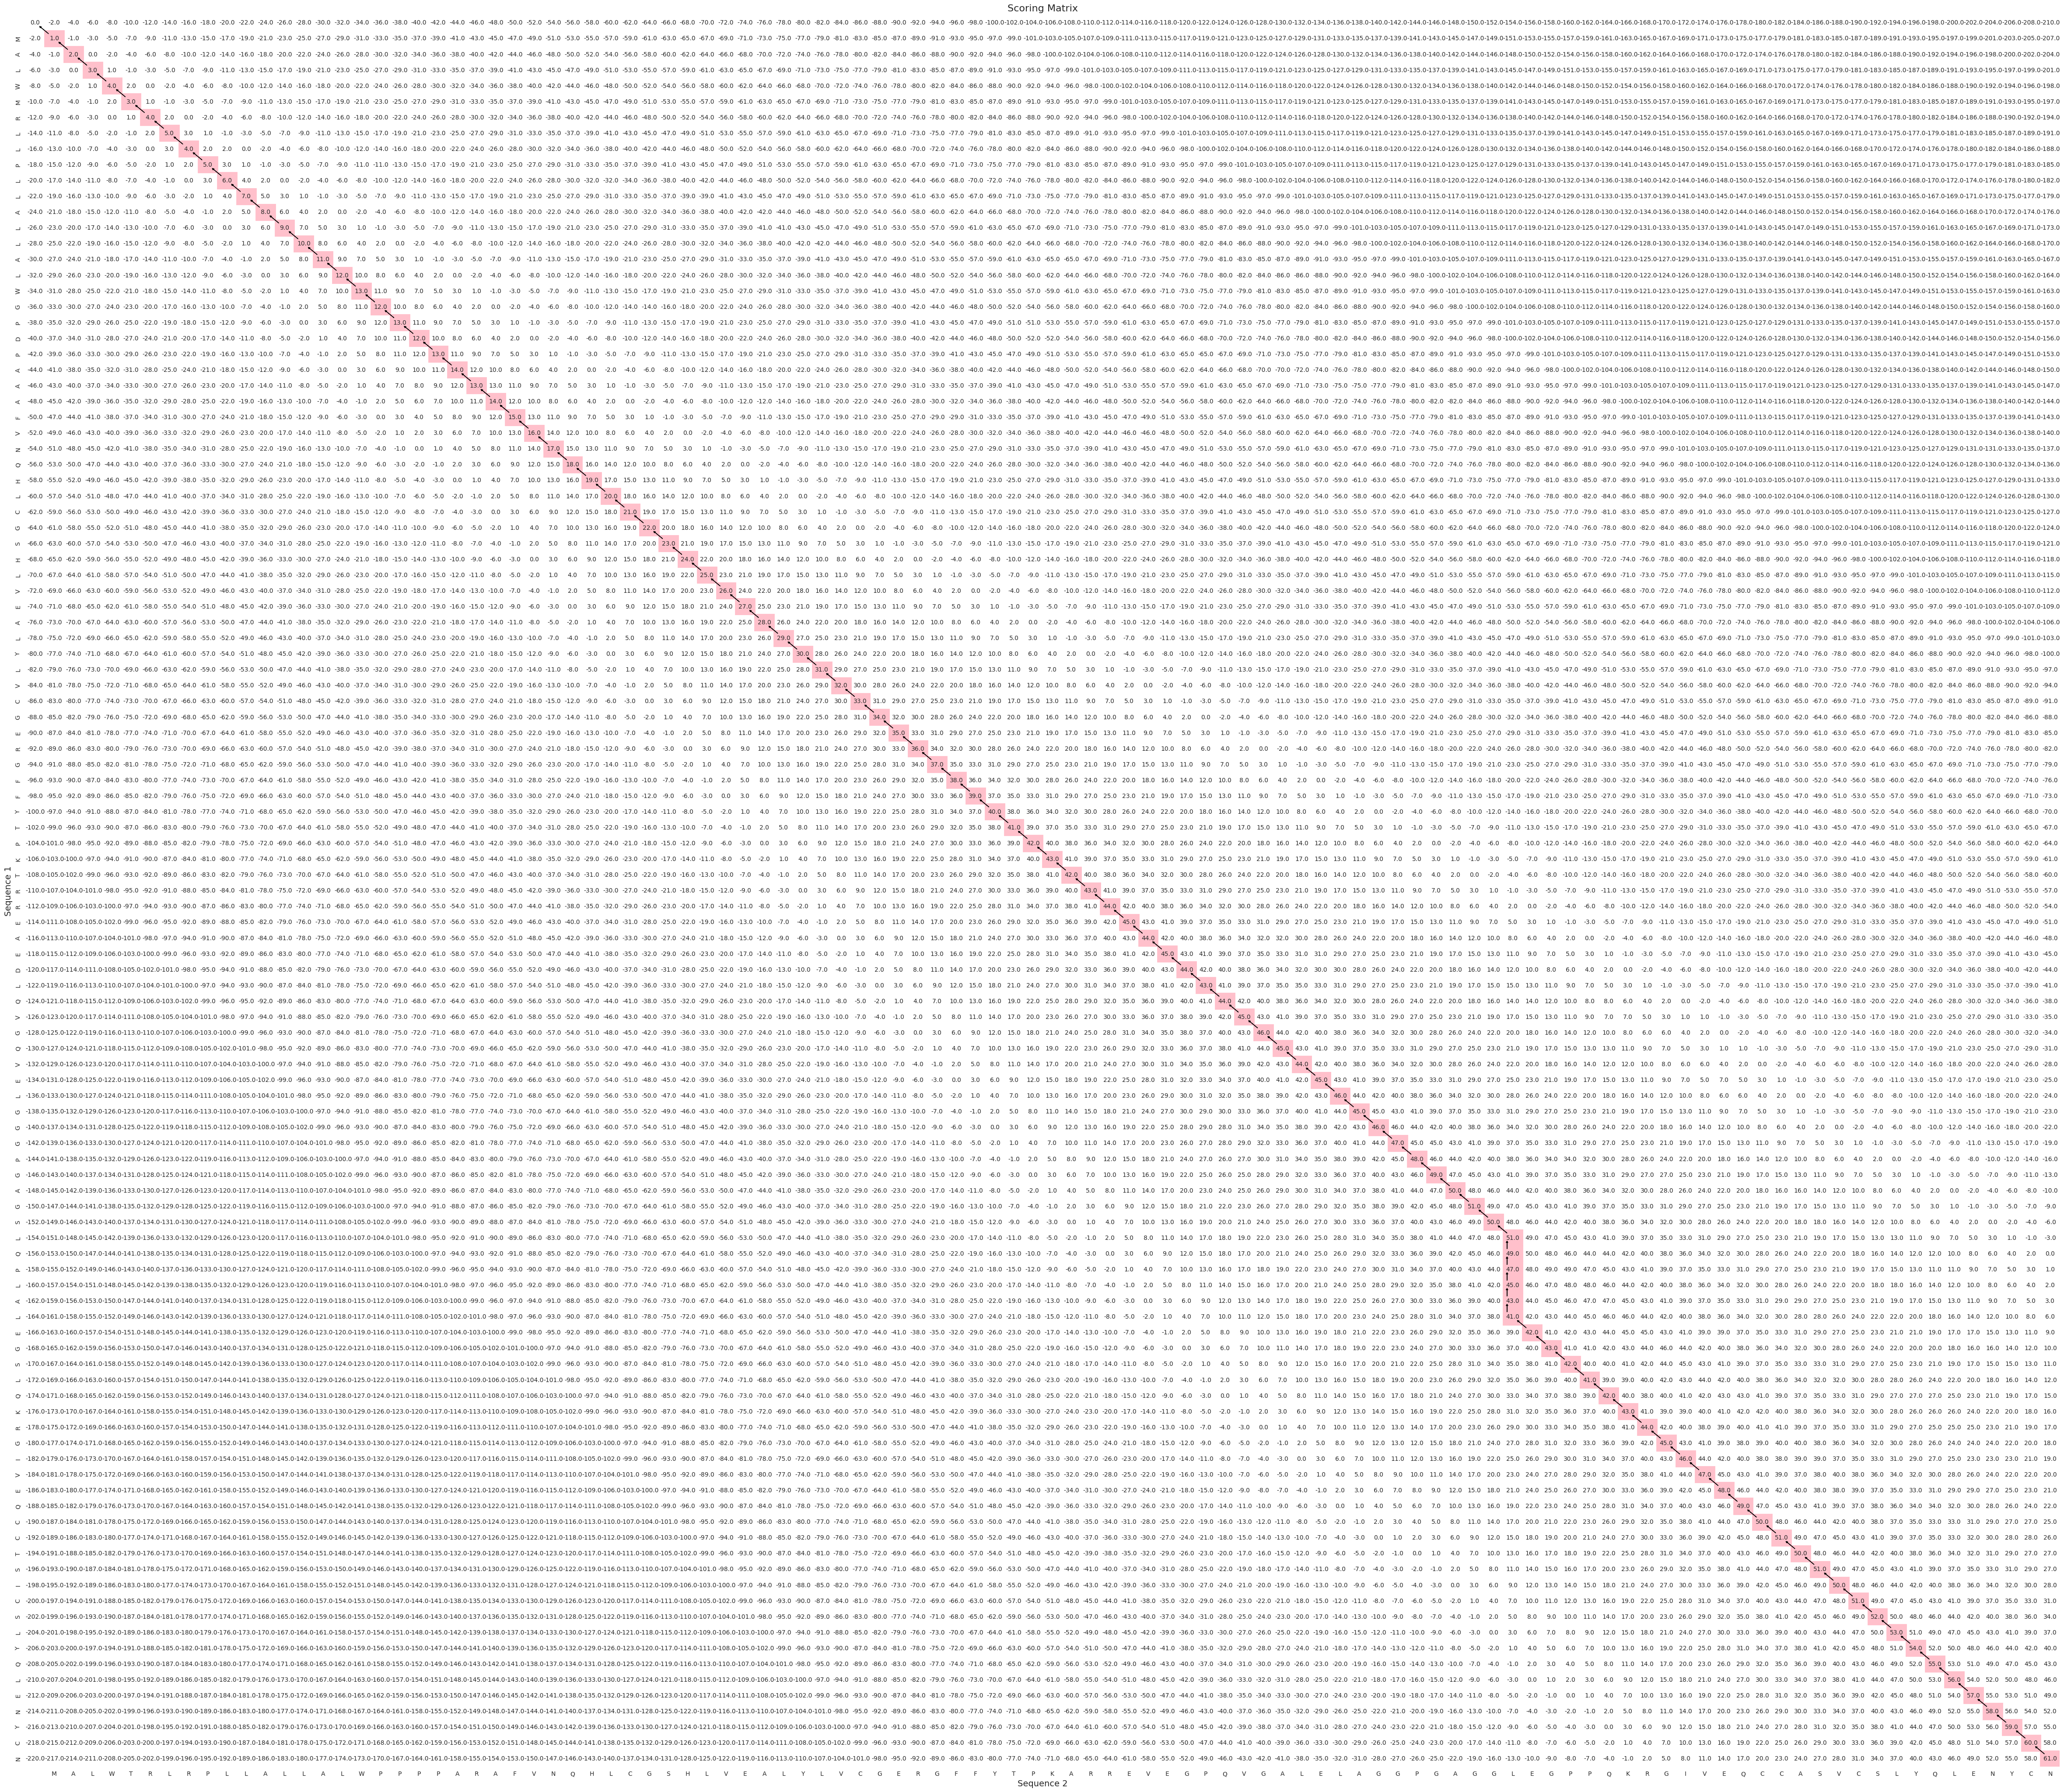

(array([[   0.,   -2.,   -4., ..., -206., -208., -210.],
       [  -2.,    1.,   -1., ..., -203., -205., -207.],
       [  -4.,   -1.,    2., ..., -200., -202., -204.],
       ...,
       [-216., -213., -210., ...,   59.,   57.,   55.],
       [-218., -215., -212., ...,   57.,   60.,   58.],
       [-220., -217., -214., ...,   55.,   58.,   61.]]), 'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN', 'MALWTRLRPLLALLALWPPPPARAFVNQHLCGSHLVEALYLVCGERGFFYTPKARREVEGPQVGALELAGGPGAGGL-----EGPPQKRGIVEQCCASVCSLYQLENYCN', 80.0)


In [ ]:
seq1 = SeqByID("P01308") # insulin human
seq2 = SeqByID("P01317") # Insulin bovin
gap = -2
win = 1
pun = -1
print(create_matrix(seq1, seq2, gap, win, pun))

#### Pseudokod

##### Funkcja initialize_matrix(seq1, seq2, kara_za_lukę):

&emsp;Oblicz długości sekwencji seq1 i seq2 i zapisz je jako n i m.  
&emsp;Inicjuj dwie puste tablice mat i mat_back, obie o wymiarach (n + 1) x (m + 1).  

&emsp;Dla i od 1 do n + 1:  
&emsp;&emsp;Ustaw wartość mat[i, 0] na mat[i - 1, 0] + kara_za_lukę.  
    
&emsp;Dla j od 1 do m + 1:  
&emsp;&emsp;Ustaw wartość mat[0, j] na mat[0, j - 1] + kara_za_lukę.  

&emsp;Zwróć zainicjowaną macierz mat oraz macierz do śledzenia kroków wstecz mat_back.  

##### Funkcja fill_matrix(seq1, seq2, kara_za_lukę, punktacja_za_dopasowanie, punktacja_za_niezgodność):

&emsp;Inicjuj kierunki ruchu dla wstecznego śledzenia: {"Góra": 1, "Lewo": 2, "Skos": 3}.  
&emsp;Inicjuj macierz i macierz wstecznego śledzenia przy użyciu funkcji initialize_matrix(seq1, seq2, kara_za_lukę).  
&emsp;Pobierz wymiary macierzy mat, n i m.  

&emsp;Dla każdego i od 1 do n - 1:  
&emsp;&emsp;Dla każdego j od 1 do m - 1:  
&emsp;&emsp;&emsp;Oblicz punktację dopasowania, biorąc pod uwagę punktację za identyczność lub niezgodność znaków.  
&emsp;&emsp;&emsp;Aktualizuj wartość w macierzy, wybierając maksimum spośród trzech możliwych ruchów:  
&emsp;&emsp;&emsp;&emsp;- Do góry + kara za lukę  
&emsp;&emsp;&emsp;&emsp;- W lewo + kara za lukę  
&emsp;&emsp;&emsp;&emsp;- Na skos + punktacja za dopasowanie lub niezgodność  
&emsp;&emsp;&emsp;Aktualizuj wartość w macierzy wstecznego śledzenia w zależności od wykonanego ruchu.  

&emsp;Zwróć wypełnioną macierz mat oraz macierz wstecznego śledzenia mat_back.  

##### Funkcja traceback_alignment(seq1, seq2, mat_back, kara_za_lukę):
 
&emsp;Inicjuj słownik kierunków ruchu dla wstecznego śledzenia: {"Góra": 1, "Lewo": 2, "Skos": 3}.  
&emsp;Inicjuj puste listy seq1_aligned i seq2_aligned na dopasowane sekwencje.  
&emsp;Pobierz wymiary macierzy mat_back, n i m.  
&emsp;Inicjuj indeksy i, j na n - 1 i m - 1.  

&emsp;Dopóki i > 0 lub j > 0:  
&emsp;&emsp;Jeśli ruch w macierzy wstecznego śledzenia wskazuje na ruch na skos:  
&emsp;&emsp;&emsp;Dodaj odpowiednie znaki z obu sekwencji do dopasowanych sekwencji.  
&emsp;&emsp;&emsp;Aktualizuj indeksy i, j o jeden w tył.  
&emsp;&emsp;W przeciwnym razie:  
&emsp;&emsp;&emsp;Jeśli ruch wskazuje na ruch do góry:  
&emsp;&emsp;&emsp;&emsp;Dodaj znak z pierwszej sekwencji i linię pominięcia do dopasowanych sekwencji.  
&emsp;&emsp;&emsp;&emsp;Aktualizuj indeks i o jeden w tył.  
&emsp;&emsp;&emsp;W przeciwnym razie:  
&emsp;&emsp;&emsp;&emsp;Dodaj znak z drugiej sekwencji i linię pominięcia do dopasowanych sekwencji.  
&emsp;&emsp;&emsp;&emsp;Aktualizuj indeks j o jeden w tył.  

&emsp;Zwróć dopasowane sekwencje, po odwróceniu ich kolejności.  

##### Funkcja calculate_similarity(seq1_aligned, seq2_aligned):
    
&emsp;Oblicz liczbę dopasowanych pozycji, sumując 1 dla każdej pary znaków na tych samych pozycjach,  
&emsp;gdzie znaki są takie same, pomiędzy seq1_aligned i seq2_aligned.  
&emsp;Oblicz całkowitą liczbę pozycji jako maksimum z długości seq1_aligned i seq2_aligned.  
&emsp;Oblicz procentowe podobieństwo, dzieląc liczbę dopasowanych pozycji przez całkowitą liczbę pozycji  
&emsp;i mnożąc przez 100. Jeśli całkowita liczba pozycji wynosi 0, zwraca 0.  

&emsp;Zwróć procentowe podobieństwo.  

##### Funkcja create_matrix(seq1, seq2, gap, win, pun):
    
&emsp;Stwórz macierz ocen i macierz wstecznego śledzenia za pomocą funkcji fill_matrix().  
&emsp;Wykonuj wyrównanie sekwencji za pomocą funkcji traceback_alignment().  
&emsp;Oblicz procentowe podobieństwo między dopasowanymi sekwencjami za pomocą funkcji calculate_similarity().  
&emsp;Inicjuj tabelę danych (df) za pomocą funkcji initialize_dataframe().  
&emsp;Stwórz nowy wiersz danych (new_row) zawierający informacje o sekwencjach, wynikach dopasowania, karach za niezgodność i lukę,  
&emsp;oraz dopasowanych sekwencjach.  
&emsp;Zapisuj nowy wiersz danych do pliku "result_n-w.txt".  
&emsp;Wyświetl informacje o parametrach dopasowania i długość wyrównanej sekwencji.  
&emsp;Wizualizuj macierz ocen i macierz wstecznego śledzenia za pomocą funkcji visualize_matrix_nw().  

&emsp;Zwróć macierz ocen, dopasowaną wersję pierwszej sekwencji, dopasowaną wersję drugiej sekwencji oraz procentowe podobieństwo.


#### Złożoność obliczeniowa algorytmu dopasowania Needlemana-Wunscha
- Funkcja initialize_matrix: $O(n^2)$
- Funkcja fill_matrix: $O(n^2)$
- Funkcja calculate_similarity: O(n), gdzie n jest dlugością najdluższej sekwencji
- Funkcja traceback_alignment: O(n)
- Funkcja visualize_matrix - $O(n^2)$

Po zsumowaniu złożoności obliczeniowych poszczególnych funkcji, można założyć, że złożoność obliczeniowa algorytmu Needlemana-Wunscha wynosi w przybliżeniu $O(n^2)$

### ALgorytm Smitha-Watermana

#### Inicjalizacja macierzy

In [ ]:
def initialize_matrices(seq1, seq2):
    """
    Initializes matrices for Smith-Waterman algorithm.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.

    Returns:
        tuple: A tuple containing two numpy arrays, `mat` and `mat_back`.
            - `mat` (numpy.ndarray): The main matrix with dimensions (n+1) x (m+1),
                where n is the length of seq1 and m is the length of seq2.
            - `mat_back` (numpy.ndarray): The backtrack matrix with dimensions (n+1) x (m+1).
    """
    
    n = len(seq1)
    m = len(seq2)
    mat = np.zeros((n + 1, m + 1))
    mat_back = mat.copy()
    return mat, mat_back

#### Wypełnianie macierzy odpowiednią punktacją oraz wypełnienie macierzy mat_back oznaczeniem ścieżki

In [ ]:
def compute_scores(mat, mat_back, seq1, seq2, win, pun, gap):
    """
    Computes scores for Smith-Waterman algorithm.

    Args:
        mat (numpy.ndarray): The main matrix for Smith-Waterman algorithm.
        mat_back (numpy.ndarray): The backtrack matrix.
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        win (int): The score for a match.
        pun (int): The penalty score for a mismatch.
        gap (int): The penalty score for a gap.

    Returns:
        tuple: A tuple containing two numpy arrays, `mat` and `mat_back`, updated with computed scores.
            - `mat` (numpy.ndarray): The updated main matrix.
            - `mat_back` (numpy.ndarray): The updated backtrack matrix.
    """
    
    directions = {"U": 1, "L": 2, "D": 3}
    
    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            match = mat[i-1, j-1] + (win if seq1[i-1] == seq2[j-1] else pun)
            mat[i, j] = max(mat[i-1, j] + gap, mat[i, j-1] + gap, match, 0)
            
            if mat[i, j] == 0:
                mat_back[i, j] = 0
            elif mat[i,j] == mat[i-1, j] + gap:
                mat_back[i, j] = directions["U"]
            elif mat[i, j] == mat[i, j-1] + gap:
                mat_back[i, j] = directions["L"]
            else:
                mat_back[i, j] = directions["D"]
    
    return mat, mat_back

#### Odpowiednie wypełnianie sekwencji dopasowania

In [ ]:
def traceback_alignment(mat, mat_back, seq1, seq2):
    """
    Performs traceback to retrieve aligned sequences from matrices.

    Args:
        mat (numpy.ndarray): The main matrix for Smith-Waterman algorithm.
        mat_back (numpy.ndarray): The backtrack matrix for Smith_waterman algorithm.
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.

    Returns:
        tuple: A tuple containing:
            - aligned_seqs (list): A list of tuples containing aligned sequences.
            - inds (numpy.ndarray): An array containing indices of maximum values in the main matrix.
    """
    
    aligned_seqs = []
    directions = {"U": 1, "L": 2, "D": 3}
    
    max_val = np.max(mat)
    inds = np.argwhere(mat == max_val)

    for ind in inds:
        i, j = ind
        seq1_aligned = []
        seq2_aligned = []
        while i > 0 and j > 0 and mat[i, j] != 0:
            if mat_back[i, j] == 0:
                break
            elif mat_back[i, j] == directions["D"]:
                seq1_aligned.append(seq1[i-1])
                seq2_aligned.append(seq2[j-1])
                i -= 1
                j -= 1
            elif mat_back[i, j] == directions["U"]:
                seq1_aligned.append(seq1[i-1])
                seq2_aligned.append('-')
                i -= 1
            elif mat_back[i, j] == directions["L"]:
                seq1_aligned.append('-')
                seq2_aligned.append(seq2[j-1])
                j -= 1
        
        seq1_aligned = ''.join(seq1_aligned[::-1])
        seq2_aligned = ''.join(seq2_aligned[::-1]) 
        
        aligned_seqs.append((seq1_aligned, seq2_aligned))
    
    return aligned_seqs, inds


#### Wizualizacja macierzy punktacji wraz z oznaczeniem ścieżek dopasowania

In [ ]:
def visualize_matrix(seq1, seq2, mat, mat_back, positions):
    """
    Visualizes the scoring matrix and alignment path.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        mat (numpy.ndarray): The scoring matrix.
        mat_back (numpy.ndarray): The backtracking matrix.

    Returns:
        None
    """
    positions = traceback_alignment(mat, mat_back, seq1, seq2)[1]
    if len(seq1) < 50 and len(seq2) < 50:
        plt.figure() 
        with sns.axes_style('white'):
            sns.heatmap(mat, cbar=False,
                        square=False,
                        annot=True,
                        fmt='.2f',  
                        cmap=ListedColormap(['white']),
                        linewidths=0.5,
                        # linecolor='black'
                        )
            
            plt.title('Scoring Matrix')
            plt.xlabel('Sequence 2')
            plt.ylabel('Sequence 1')
            plt.xticks(np.arange(len(seq2)+1)+0.5, [''] + list(seq2))
            plt.yticks(np.arange(len(seq1)+1)+0.5, [''] + list(seq1))
            for pos in positions:
                i, j = pos
                while i > 0 and j > 0 and mat_back[i, j] != 0:
                    if mat_back[i, j] == 3:
                        plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor='pink', edgecolor='pink', lw=2))
                        i -= 1
                        j -= 1
                    elif mat_back[i, j] == 1:   
                        plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor='pink', edgecolor='pink', lw=2))
                        i -= 1
                    elif mat_back[i, j] == 2:  
                        plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor='pink', edgecolor='pink', lw=2))
                        j -= 1
            for pos in positions:
                i, j = pos
                while i > 0 and j > 0 and mat_back[i, j] != 0:
                    if mat_back[i, j] == 3:
                        plt.arrow(j + 0.2, i + 0.2, -0.4, -0.4, head_width=0.1, head_length=0.1, fc='black', ec='black')
                        i -= 1
                        j -= 1
                    elif mat_back[i, j] == 1:   
                        plt.arrow(j + 0.2, i + 0.2, 0, -0.4, head_width=0.1, head_length=0.1, fc='black', ec='black')
                        i -= 1
                    elif mat_back[i, j] == 2:  
                        plt.arrow(j + 0.2, i + 0.2, -0.4, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
                        j -= 1

    else:    
        plt.figure(figsize=(60, 52))  
        with sns.axes_style('white'):
            sns.heatmap(mat, cbar=False,
                        square=False,
                        annot=True,
                        fmt='.1f',  
                        cmap=ListedColormap(['white']),
                        linewidths=0.5,
                        # linecolor='black'
                        )
            
            plt.title('Scoring Matrix', fontsize=16)
            plt.xlabel('Sequence 2', fontsize=14)
            plt.ylabel('Sequence 1', fontsize=14)
            plt.xticks(np.arange(len(seq2)+1)+0.5, [''] + list(seq2))
            plt.yticks(np.arange(len(seq1)+1)+0.5, [''] + list(seq1))
        
        for pos in positions:
            i, j = pos
            while i > 0 and j > 0 and mat_back[i, j] != 0:
                if mat_back[i, j] == 3:
                    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor='pink', edgecolor='pink', lw=2))
                    i -= 1
                    j -= 1
                elif mat_back[i, j] == 1:   
                    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor='pink', edgecolor='pink', lw=2))
                    i -= 1
                elif mat_back[i, j] == 2:  
                    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor='pink', edgecolor='pink', lw=2))
                    j -= 1

        for pos in positions:
            i, j = pos
            while i > 0 and j > 0 and mat_back[i, j] != 0:
                if mat_back[i, j] == 3:
                    plt.arrow(j + 0.2, i + 0.2, -0.4, -0.4, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    i -= 1
                    j -= 1
                elif mat_back[i, j] == 1:   
                    plt.arrow(j + 0.2, i + 0.2, 0, -0.4, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    i -= 1
                elif mat_back[i, j] == 2:  
                    plt.arrow(j + 0.2, i + 0.2, -0.4, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
                    j -= 1       
    plt.show()


#### Stworzenie i wizualizacja macierzy punktacji

In [ ]:
def create_matrix_sw(seq1, seq2, win, pun, gap):
    """
    Performs Smith-Waterman algorithm for sequence alignment and visualizes the alignment.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        win (int or float): The score for a match.
        pun (int or float): The score for a mismatch.
        gap (int or float): The gap penalty.

    Returns:
        Tuple[numpy.ndarray, List[Tuple[str, str]]]: A tuple containing:
            - The filled scoring matrix.
            - List of tuples containing aligned sequences.
    """
    
    mat, mat_back = initialize_matrices(seq1, seq2)
    mat, mat_back = compute_scores(mat, mat_back, seq1, seq2, win, pun, gap)
    aligned_seqs, positions = traceback_alignment(mat, mat_back, seq1, seq2)
    visualize_matrix(seq1, seq2, mat, mat_back, positions)

    agreement = 0
    total_positions = 0
    seq1_aligned = []
    seq2_aligned = []

    for seq1_align, seq2_align in aligned_seqs:
        total_positions += max(len(seq1_align), len(seq2_align))
        for i in range(min(len(seq1_align), len(seq2_align))):
            if seq1_align[i] == seq2_align[i]:
                agreement += 1

        seq1_aligned.append(seq1_align)
        seq2_aligned.append(seq2_align)

    df = initialize_dataframe()

    for seq1_align, seq2_align in zip(seq1_aligned, seq2_aligned):
        percent_similarity = (agreement / total_positions) * 100 if total_positions != 0 else 0

        new_row = {'Sequence 1:': seq1, 'Sequence 2: ': seq2, 'Match score:': win, 
                    'Mismatch score:': pun, 'Gap score:': gap, 'Sequence 1 aligned:': seq1_align, 
                    'Sequence 2 aligned:': seq2_align, 'Match length': len(seq1_align), 
                    'Percentage of identical items': percent_similarity}

        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    write_to_file(df, "result_s-w.txt")

    return mat, aligned_seqs

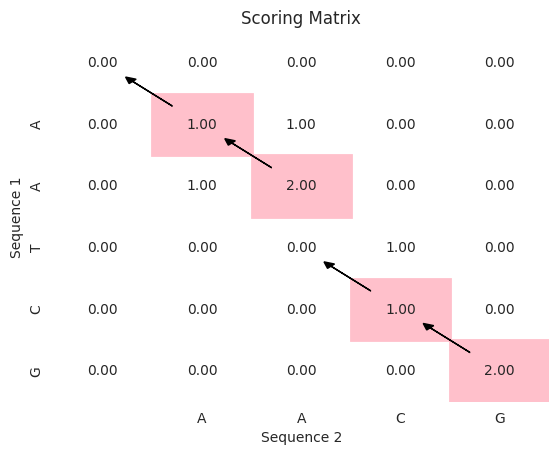

Alignment Matrix:
[[0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 2.]]

Aligned Sequences:
Alignment 1:
AA
AA

Alignment 2:
CG
CG



In [ ]:
s1 = 'AATCG'
s2 = 'AACG'
win = 1
pun = -1
gap = -2
matrix, aligned_sequences = create_matrix_sw(s1, s2, win, pun, gap)
print("Alignment Matrix:")
print(matrix)
print("\nAligned Sequences:")
for i, (seq1_aligned, seq2_aligned) in enumerate(aligned_sequences):
    print(f"Alignment {i+1}:")
    print(seq1_aligned)
    print(seq2_aligned)
    print()

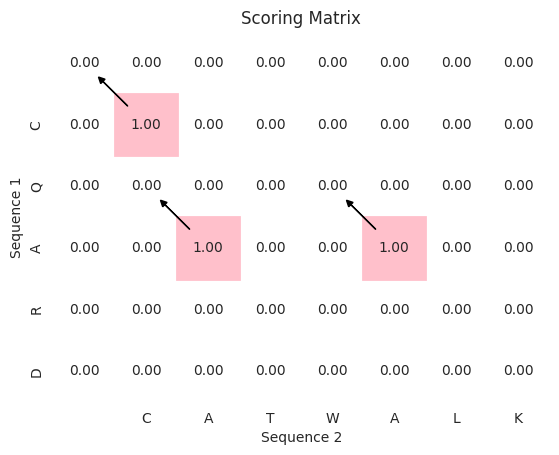

Alignment Matrix:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

Aligned Sequences:
Alignment 1:
C
C

Alignment 2:
A
A

Alignment 3:
A
A



In [ ]:
s1 = 'CQARD'
s2 = 'CATWALK'
win = 1
pun = -1
gap = -2
matrix, aligned_sequences = create_matrix_sw(s1, s2, win, pun, gap)
print("Alignment Matrix:")
print(matrix)
print("\nAligned Sequences:")
for i, (seq1_aligned, seq2_aligned) in enumerate(aligned_sequences):
    print(f"Alignment {i+1}:")
    print(seq1_aligned)
    print(seq2_aligned)
    print()

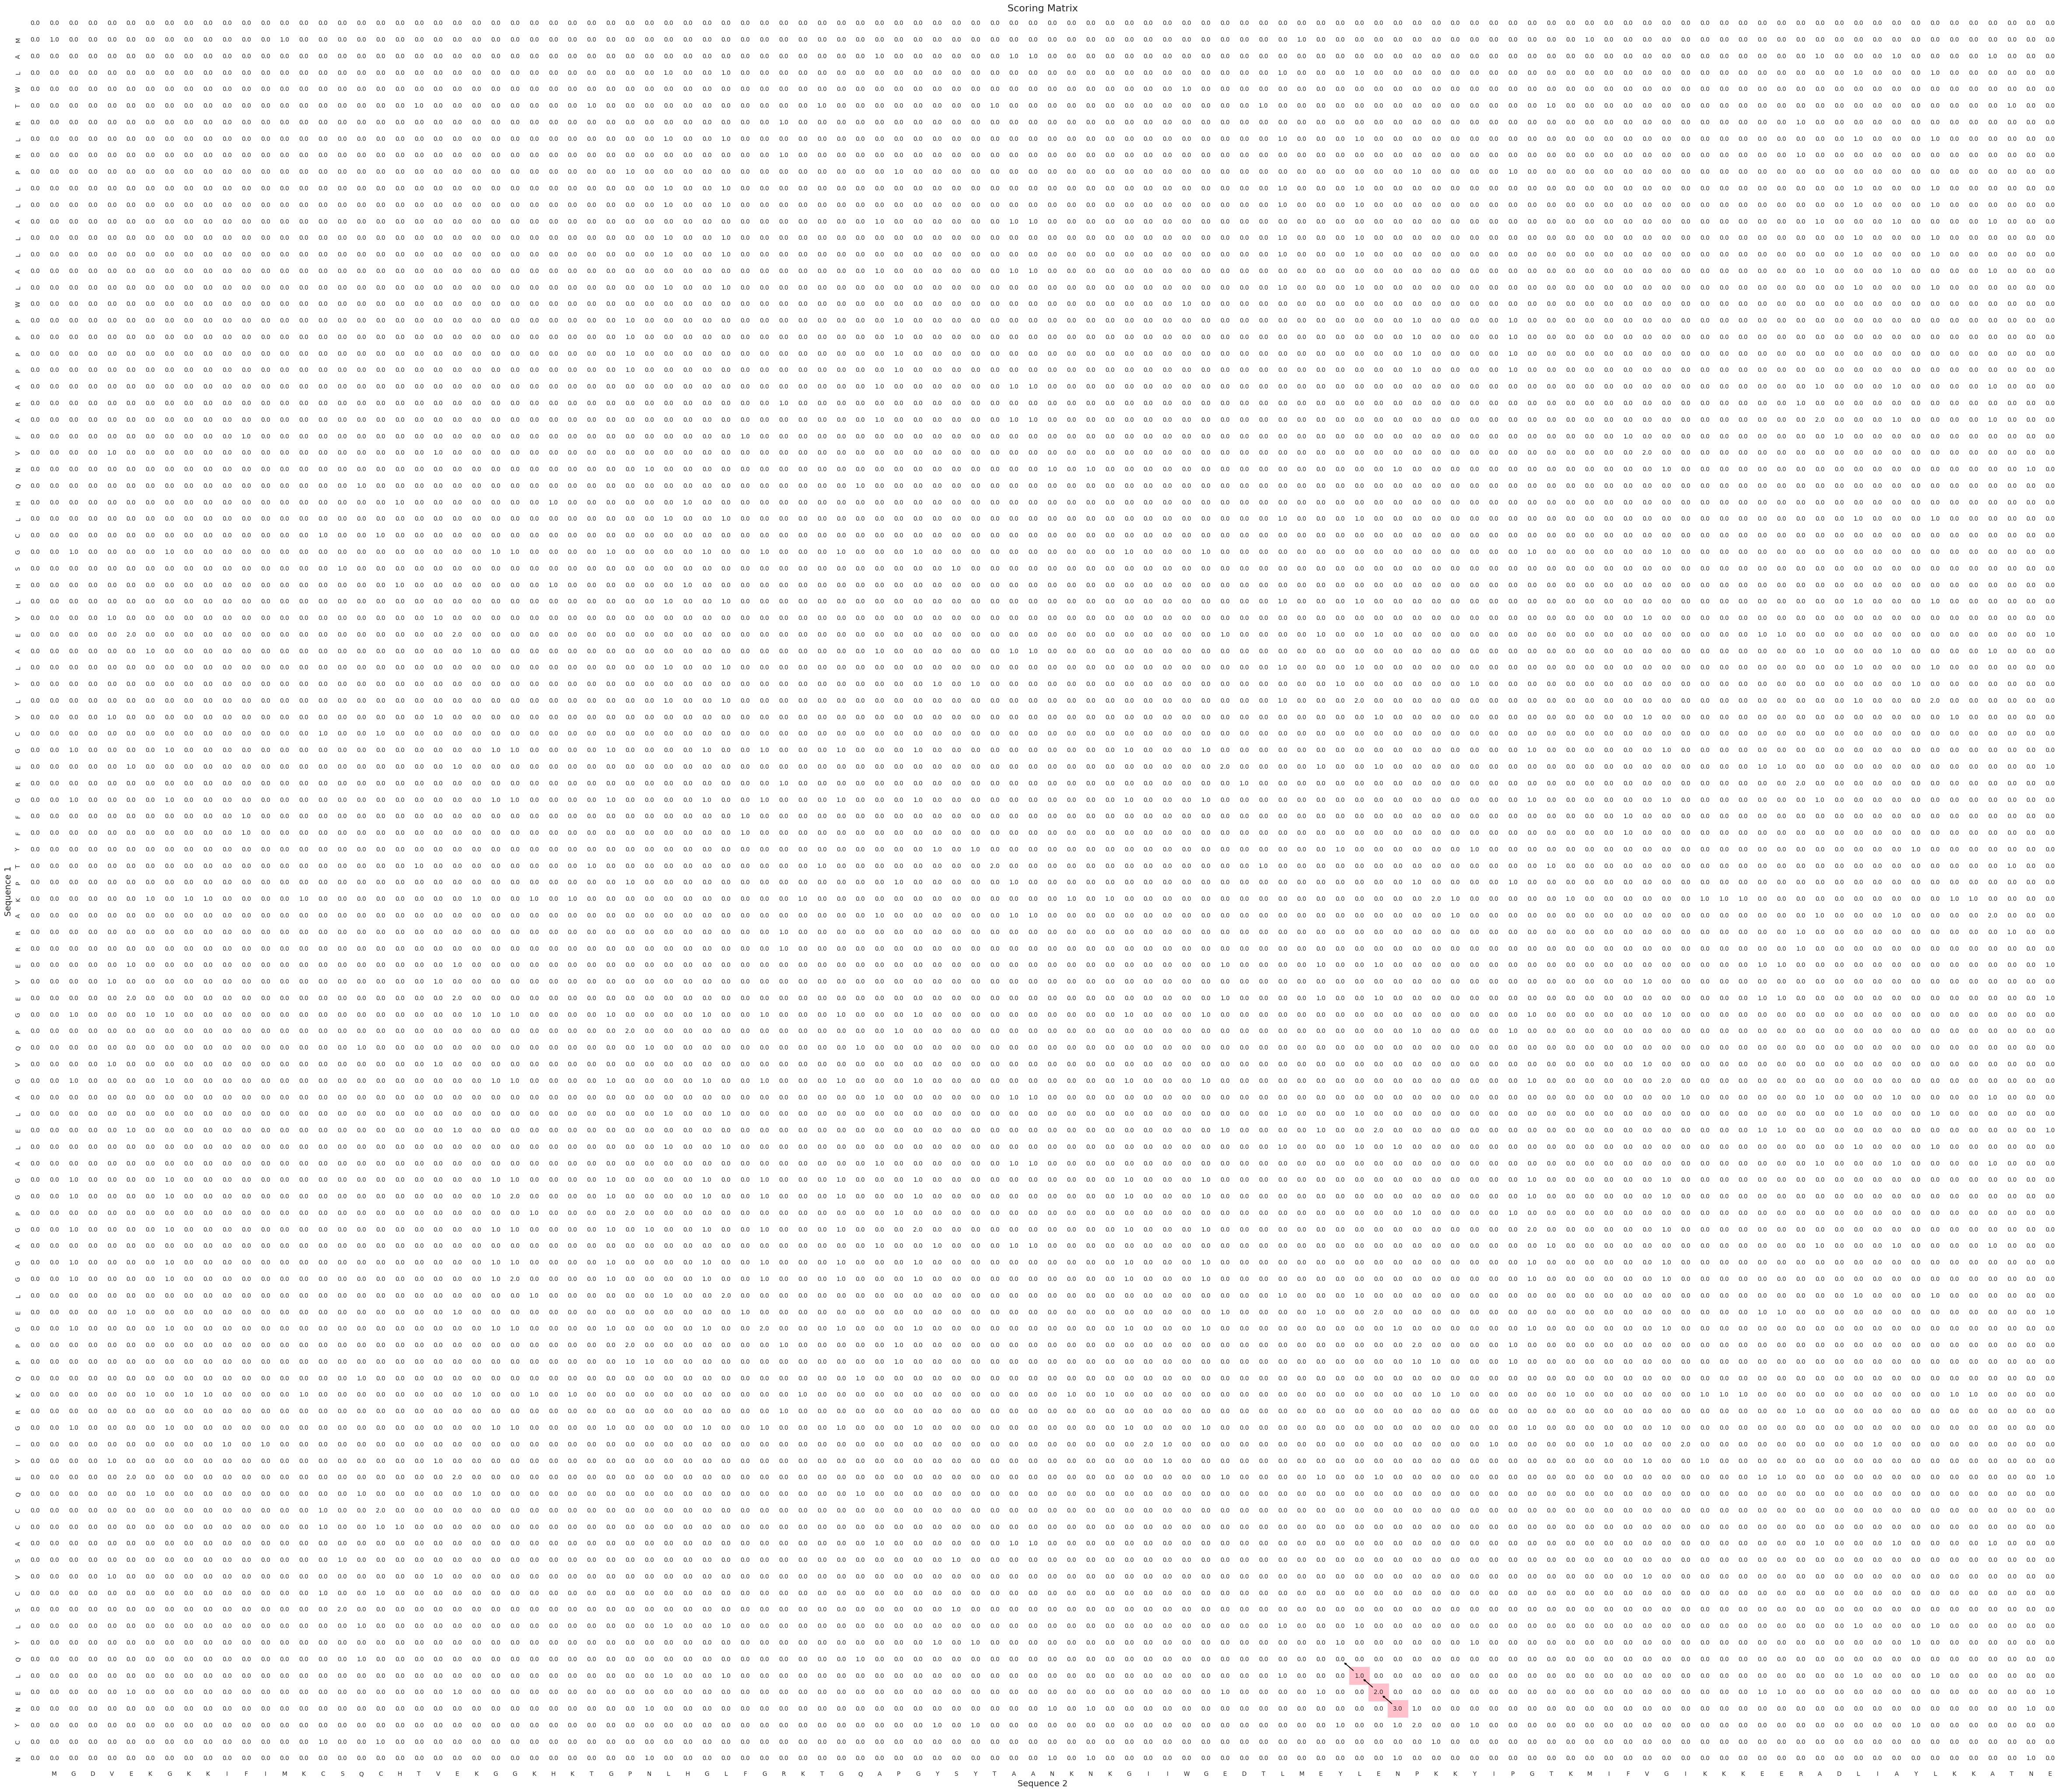

Alignment Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

Aligned Sequences:
Alignment 1:
LEN
LEN



In [ ]:
s1 = SeqByID('P01317')
s2 = SeqByID('P99999') # Cytochrome c
win = 1
pun = -1
gap = -2
matrix, aligned_sequences = create_matrix_sw(s1, s2, win, pun, gap)
print("Alignment Matrix:")
print(matrix)
print("\nAligned Sequences:")
for i, (seq1_aligned, seq2_aligned) in enumerate(aligned_sequences):
    print(f"Alignment {i+1}:")
    print(seq1_aligned)
    print(seq2_aligned)
    print()

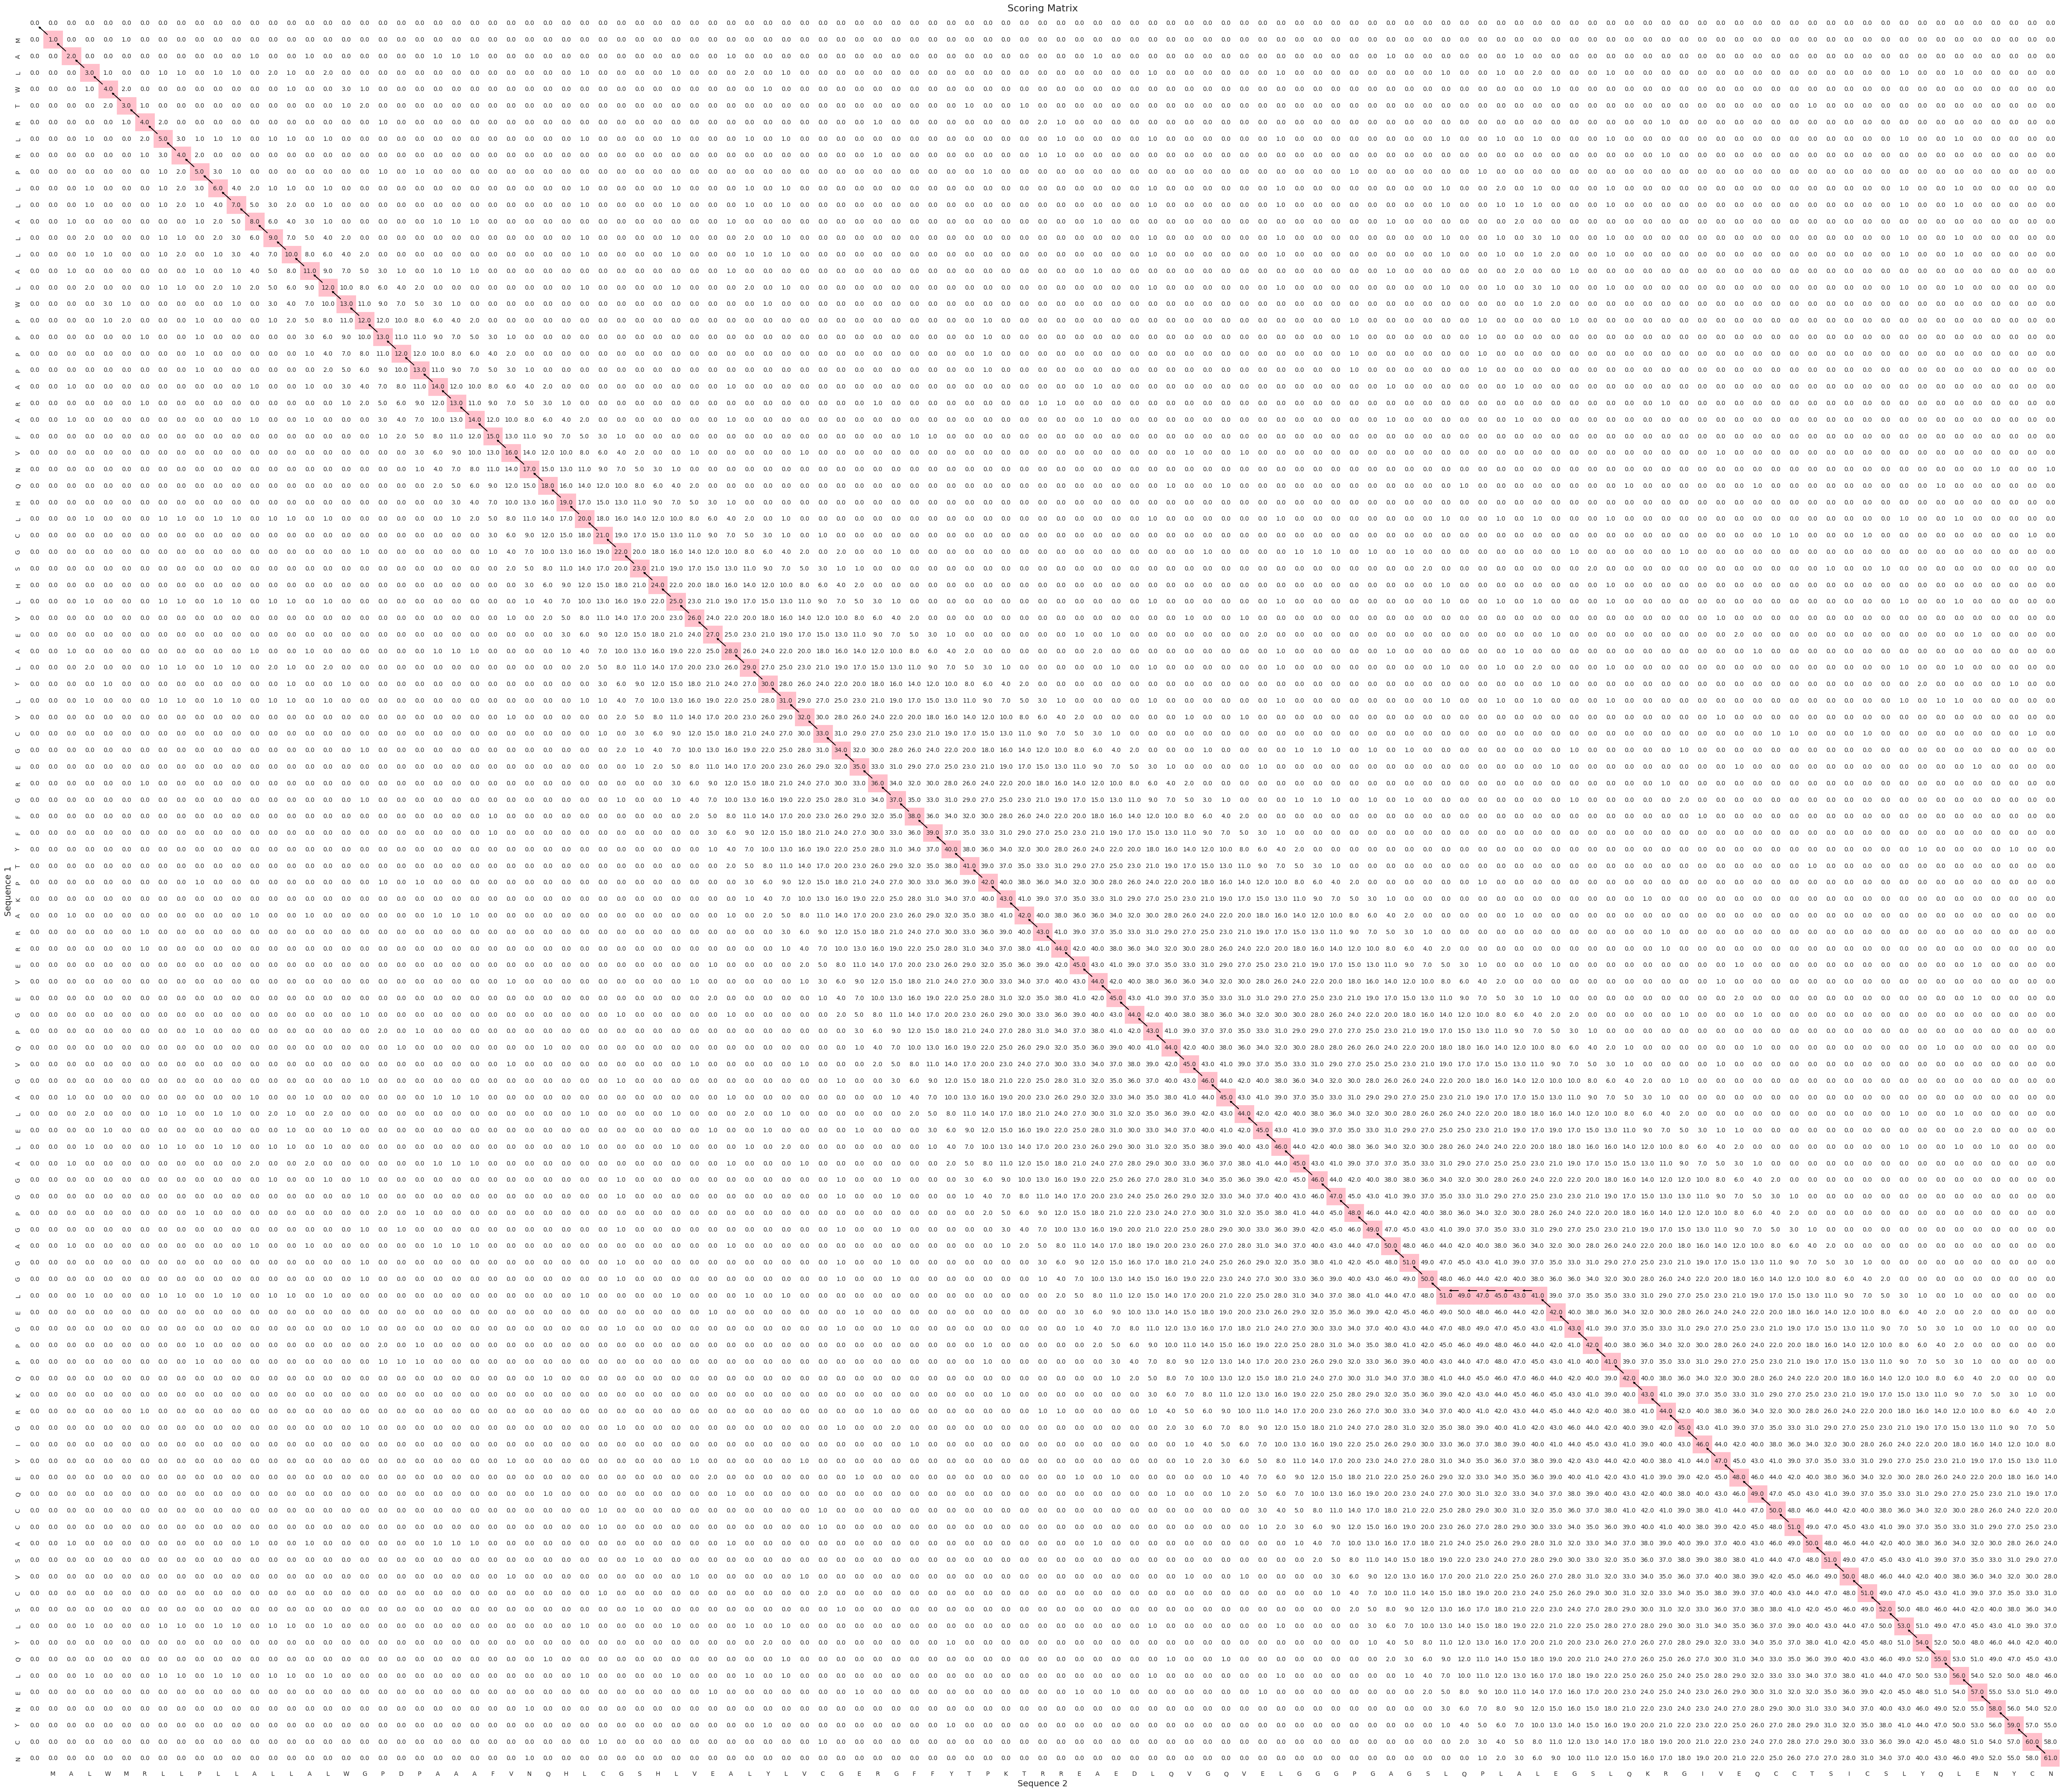

Alignment Matrix:
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 59. 57. 55.]
 [ 0.  0.  0. ... 57. 60. 58.]
 [ 0.  0.  0. ... 55. 58. 61.]]

Aligned Sequences:
Alignment 1:
MALWTRLRPLLALLALWPPPPARAFVNQHLCGSHLVEALYLVCGERGFFYTPKARREVEGPQVGALELAGGPGAGGL-----EGPPQKRGIVEQCCASVCSLYQLENYCN
MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN



In [ ]:
s1 = SeqByID('P01317')
s2 = SeqByID('P01308')
win = 1
pun = -1
gap = -2
matrix, aligned_sequences = create_matrix_sw(s1, s2, win, pun, gap)
print("Alignment Matrix:")
print(matrix)
print("\nAligned Sequences:")
for i, (seq1_aligned, seq2_aligned) in enumerate(aligned_sequences):
    print(f"Alignment {i+1}:")
    print(seq1_aligned)
    print(seq2_aligned)
    print()

#### Funkcja initialize_matrices(seq1, seq2):
&emsp;Ustaw wartość n na długość seq1.  
&emsp;Ustaw wartość m na długość seq2.  
&emsp;Inicjuj tablicę mat o wymiarach (n + 1) x (m + 1), wypełnioną zerami.  
&emsp;Inicjuj tablicę mat_back o wymiarach (n + 1) x (m + 1), wypełnioną zerami.  

&emsp;Zwróć mat i mat_back.  

#### Funkcja compute_scores(mat, mat_back, seq1, seq2, win, pun, gap):

&emsp;Oblicza wyniki dla dynamicznego programowania wyrównania.  

&emsp;Inicjuj słownik nazwany directions, gdzie kluczami są nazwy kierunków.  
&emsp;Dla każdego i od 1 do długości seq1 + 1:  
&emsp;&emsp;Dla każdego j od 1 do długości seq2 + 1:  
&emsp;&emsp;&emsp;Oblicz wynik dopasowania, uwzględniając wynik za identyczność lub niezgodność znaków.  
&emsp;&emsp;&emsp;Aktualizuj wartość w macierzy, wybierając maksimum spośród trzech możliwych ruchów:  
&emsp;&emsp;&emsp;&emsp;- W górę + kara za lukę  
&emsp;&emsp;&emsp;&emsp;- W lewo + kara za lukę  
&emsp;&emsp;&emsp;&emsp;- Dopasowanie + wynik lub kara za niezgodność  
&emsp;&emsp;&emsp;Aktualizuj wartość w macierzy wstecznego śledzenia w zależności od wykonanego ruchu.  

&emsp;Zwróć mat i mat_back.  

#### Funkcja traceback_alignment(mat, mat_back, seq1, seq2):
&emsp;Utwórz pustą listę o nazwie aligned_seqs.  
&emsp;Utwórz słownik nazwany directions, gdzie kluczami są nazwy ruchów.  

&emsp;Znajdź największą wartość w macierzy mat i zapisz ją jako max_val.  
&emsp;Znajdź wszystkie indeksy, gdzie wartość w macierzy mat jest równa max_val, i zapisz je jako inds.  

&emsp;Dla każdego zestawu indeksów (i, j) w inds:  
&emsp;&emsp;Ustaw zmienne i i j na wartości indeksów.  
&emsp;&emsp;Utwórz puste listy seq1_aligned i seq2_aligned na wyrównane sekwencje.  

&emsp;&emsp;Dopóki i jest większe od 0 i j jest większe od 0, i wartość w macierzy mat nie wynosi 0:  
&emsp;&emsp;&emsp;Jeśli ruch w macierzy wstecznego śledzenia wskazuje na ruch na skos:  
&emsp;&emsp;&emsp;&emsp;Dodaj odpowiednie znaki z obu sekwencji do wyrównanych sekwencji.  
&emsp;&emsp;&emsp;&emsp;Zmniejsz wartości i i j o 1.  
&emsp;&emsp;&emsp;Jeśli ruch w macierzy wstecznego śledzenia wskazuje na ruch do góry:  
&emsp;&emsp;&emsp;&emsp;Dodaj znak z pierwszej sekwencji i pominięcie do wyrównanych sekwencji.  
&emsp;&emsp;&emsp;&emsp;Zmniejsz wartość i o 1.  
&emsp;&emsp;&emsp;Jeśli ruch w macierzy wstecznego śledzenia wskazuje na ruch w lewo:  
&emsp;&emsp;&emsp;&emsp;Dodaj znak z drugiej sekwencji i pominięcie do wyrównanych sekwencji.  
&emsp;&emsp;&emsp;&emsp;Zmniejsz wartość j o 1.  

&emsp;&emsp;Przekształć wyrównane sekwencje w ciągi znaków.  
&emsp;&emsp;Dodaj wyrównane sekwencje do listy aligned_seqs.  

&emsp;Zwróć listę aligned_seqs oraz tablicę inds.  

#### Funkcja create_matrix_sw(seq1, seq2, win, pun, gap):  

&emsp;Inicjuj macierz ocen i macierz wstecznego śledzenia za pomocą funkcji initialize_matrices(seq1, seq2).  
&emsp;Oblicz wyniki ocen za pomocą funkcji compute_scores(mat, mat_back, seq1, seq2, win, pun, gap).  
&emsp;Wykonaj wyrównanie sekwencji za pomocą funkcji traceback_alignment(mat, mat_back, seq1, seq2).  
&emsp;Wizualizuj macierz ocen za pomocą funkcji visualize_matrix(seq1, seq2, mat, mat_back, positions).  

&emsp;Inicjuj zmienne agreement i total_positions na 0.  
&emsp;Inicjuj zmienne seq1_aligned i seq2_aligned na puste ciągi znaków.  

&emsp;Dla każdej krotki seq1_align, seq2_align w aligned_seqs:  
&emsp;&emsp;Zwiększ total_positions o maksimum długości seq1_align i seq2_align.  
&emsp;&emsp;Dla każdego i w zakresie od 0 do minimum długości seq1_align i seq2_align:  
&emsp;&emsp;&emsp;Jeśli seq1_align[i] == seq2_align[i]:  
&emsp;&emsp;&emsp;&emsp;Zwiększ agreement o 1.  

&emsp;&emsp;&emsp;Dołącz seq1_align do seq1_aligned.  
&emsp;&emsp;&emsp;Dołącz seq2_align do seq2_aligned.  

&emsp;Oblicz procent podobieństwa jako (agreement / total_positions) * 100, jeśli total_positions != 0, w przeciwnym razie 0.  

&emsp;Wyświetl informacje o parametrach: Kary: pun, Wynik: win, Kary za lukę: gap, Procent identycznych pozycji: percent_similarity.  

&emsp;Inicjuj tabelę danych df za pomocą funkcji initialize_dataframe().  
&emsp;Stwórz nowy wiersz danych new_row zawierający informacje o sekwencjach, wynikach dopasowania, karach za niezgodność i lukę,  
&emsp;&emsp;oraz dopasowanych sekwencjach.  
&emsp;Zapisz nowy wiersz danych do pliku "result_s-w.txt".  

&emsp;Zwróć mat i aligned_seqs.  


#### Złożoność obliczeniowa
- Funkcja initialize_matrices: $O(n^2)$
- Funkcja compute_scores: $O(n^2)$
- Funkcja traceback_alignment: $O(n^2)$
- Funkcja visualize_matrix: $O(n^2)$

Zatem po zsumowaniu poszczególnych złożoności obliczeniowych można założyć, w całkowita złożoność obliczeniowa algorytmu Smitha-Watermana wynosi w przybliżeniu $O(n^2)$.